# Semantic Role Labelling
Welcome to Homework 7 where we will be running the task of semantic role labelling. Semantic Role Labelling or SRL for short, is the task of assigning roles to phrases or words in sentences, assigning their semantic role such as the agent, goal or result, and is a key process to understanding meaning to the sentence. 

This is done by identifying the verb in the sentence and also the associated arguments to the verbs, which can then be labelled according to the semantic role they play. We will be focusing on the verb identification and argument labelling aspect of this.

The way we will be doing this is treating it as sequence to sequence classification task. Note that we will be following a different architecture here:
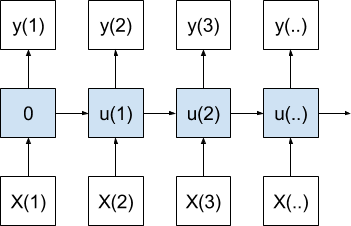

We will be also introducing the concept of Dataset and Dataloaders, which are very useful to load data for pytorch models.

We highly recommend you do this assignment on Colab (which would be free), or on an environment with a GPU.
If you are using Colab, remember to go to Runtime -> Change runtime type -> select GPU

# Data

We will be providing the labelled training and validation data, for training purposes. You are expected to run the model on the given unlabelled test data for training purposes

#Evaluation

You will be evaluated on a hidden test set, which is not avilable to you. Your model, if correctly implemented and trained, should cross the hidden minimum threshold. We will also be looking at your validation and train-time metrics, such as the losses and macro f1- metrics.

#Submission

The last cell of this notebook has the code for creating the submission files. Please do not change the name of the output files and upload the generated files to the autograder.

In [ ]:
!pip install torchmetrics matplotlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score
import torch.optim as optim
from torch.optim import lr_scheduler
import random
import tqdm
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt

# from tqdm import tqdm
from tqdm.auto import tqdm


## Reading data and desigining Data loader
Data loading is one of the first steps in building a Deep Learning pipeline, or training a model. This task becomes more challenging when the complexity of the data increases. In this section, you will learn about the DataLoader class in PyTorch that helps us to load and iterate over elements in a dataset.

Here we provide a simplified encoding of the labels you will see in the train and validation dataset. For example, "v" refers to the verb, whereas "c" is short for "c-*", i.e. a span which is a continuation of any of the other arguments present in the sentence and is usually labelled as  "c-A0" or "C- A1" and so on. You can read up more on the different labels at the [CoNLL's website](https://www.cs.upc.edu/~srlconll/spec.html)

In [ ]:
LABEL2INDEX = {'a1': 0,
 'na': 1,
 'a0': 2,
 'v': 3,
 'c': 4,
 'am': 5,
 'a2': 6,
 'am-neg': 7,
 'a3': 8,
 'r': 9,
 'a4': 10,
 'a5': 11}

# Here we recommend you create a reverse labelling of the labels for inference purposes
INDEX2LABEL= { item:key for key,item in LABEL2INDEX.items()}#TODO

In [ ]:
INDEX2LABEL

{0: 'a1',
 1: 'na',
 2: 'a0',
 3: 'v',
 4: 'c',
 5: 'am',
 6: 'a2',
 7: 'am-neg',
 8: 'a3',
 9: 'r',
 10: 'a4',
 11: 'a5'}

In [ ]:
class WordDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, label_path, word_mapping=None):

        if word_mapping:
            self.WORD2INDEX = word_mapping
        if not word_mapping:
            self.WORD2INDEX = {
                           "UNK":0}

        self.LABEL2INDEX=LABEL2INDEX
        self.X=[]
        self.Y=[]
        i_ptr=1
        
        with open(data_path,"r") as f:
            i = []
            for line in f:
                word=line.strip().lower()
                if len(word) > 0 :
                    i.append(word)

                    if not word_mapping and word not in self.WORD2INDEX:
                        self.WORD2INDEX[word] = i_ptr
                        i_ptr+=1

                if len(word) == 0  and len(i) > 0:
                    self.X.append(i)
                    i=[]
                if len(word) == 0 and len(i) == 0:
                    continue
            self.X.append(i)
                       
        with open(label_path,"r") as f:
            i = []
            for line in f:
                thing = line.strip().lower()
                if line == "\n" and len(i) > 0:
                    self.Y.append(i)
                    i=[]
                elif line!='\n':
                    if thing not in self.LABEL2INDEX:
                        i.append(self.LABEL2INDEX["na"])    
                    else:
                        i.append(self.LABEL2INDEX[thing])    
            self.Y.append(i)
        self.X_encoded=[]
        
        for sentence in self.X:
            enc = []
            for word in sentence:
                enc.append(self.WORD2INDEX.get(word.lower(),self.WORD2INDEX["UNK"]))
            self.X_encoded.append(enc)
        
        
        assert(len(self.X_encoded) == len(self.Y))
        assert(len(self.X_encoded[1]) == len(self.Y[1]))

    def __len__(self):
       return len(self.X_encoded) # TODO: return the length of the encoded X
        


    def __getitem__(self, ind):

        
        X = self.X_encoded[ind] # TODO: get the 'ind' index from the encoded X and convert it into an array
        
        X = torch.LongTensor(X) #TODO: convert the array to a LongTensor
        
        Y =  torch.LongTensor(self.Y[ind]) # TODO: Get the 'ind' index from Y and convert it to a LongTensor

        return X, Y
    
    def collate_fn(self, batch):

        # TODO
        batch_x = [x for x,y in batch]
        batch_y = [y for x,y in batch]

        batch_x_pad = pad_sequence(batch_x, batch_first = True) # TODO: pad the sequence with pad_sequence (already imported) for x's- please look at how it is implemented and make sure to set batch_first as True
        lengths_x = [len(x) for x in batch_x] # TODO: Get original lengths of the sequence before padding

        batch_y_pad = pad_sequence(batch_y, batch_first = True)# TODO: pad the sequence with pad_sequence (already imported) for y's - please look at how it is implemented and make sure to set batch_first as True
        lengths_y =  [len(y) for y in batch_y] # TODO: Get original lengths of the sequence before padding

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)



In [ ]:
class WordTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_path,word_mapping):

        if word_mapping:
            self.WORD2INDEX = word_mapping
        

        self.X=[]
        
        with open(data_path,"r") as f:
            i = []
            for line in f:
                word=line.strip().lower()
                if len(word) > 0 :
                    i.append(word)

                if len(word) == 0  and len(i) > 0:
                    self.X.append(i)
                    i=[]
                if len(word) == 0 and len(i) == 0:
                    continue
            self.X.append(i)
                       

        self.X_encoded=[]
        for sentence in self.X:
            enc = []
            for word in sentence:
                enc.append(self.WORD2INDEX.get(word.lower(), self.WORD2INDEX["UNK"]))
            self.X_encoded.append(enc)
        

    def __len__(self):
        
        return len(self.X_encoded) # TODO: follow something similar to the train data loader


    def __getitem__(self, ind):

        # TODO: follow something similar to the train data loader, but there wold be something missing during the Test time 
        X = self.X_encoded[ind]
        X = torch.LongTensor(X)
        return X
    
    def collate_fn(self, batch):

        # TODO
        batch_x = [x for x in batch]#TODO: follow something similar to the train dataLoader

        batch_x_pad = pad_sequence(batch_x, batch_first = True)# TODO: pad the sequence with pad_sequence (already imported)
        lengths_x = [len(x) for x in batch_x]# TODO: Get original lengths of the sequence before padding


        return batch_x_pad, torch.tensor(lengths_x)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/NLP HW7

/content/drive/MyDrive/Colab Notebooks/NLP HW7


In [ ]:
!ls

HW7_SemanticRoleLabelling_Handout.ipynb  train_data.txt   val_data.txt
test_data.txt				 train_label.txt  val_label.txt


In [ ]:
train_data = WordDataset(data_path = "train_data.txt", label_path = "train_label.txt")

In [ ]:
# Defining datasets
batch_size=100
train_data = WordDataset(data_path = "train_data.txt", label_path = "train_label.txt") # TODO: Call the WordDataset for the training data 
val_data = WordDataset(data_path = "val_data.txt", label_path = "val_label.txt", word_mapping= train_data.WORD2INDEX) # TODO: Call the WordDataset for the validation data 
test_data = WordTestDataset(data_path = "test_data.txt", word_mapping = train_data.WORD2INDEX) # TODO: Call the WordTestDataset for the testing data 

# Defining the Dataloaders
train_loader = data.DataLoader(train_data, batch_size = batch_size, collate_fn = train_data.collate_fn, pin_memory= True, shuffle = True) # TODO: Define the train loader. Remember to pass in a parameter (function) for the collate_fn argument, and remember to set the pin_memory to True. What would the shuffle parameter be? 
val_loader = data.DataLoader(val_data, batch_size = batch_size, collate_fn = val_data.collate_fn, pin_memory= True, shuffle = False) # TODO: Define the val loader. Remember to pass in a parameter (function) for the collate_fn argument , and remember to set the pin_memory to True. What would the shuffle parameter be?
test_loader = data.DataLoader(test_data, batch_size = batch_size, collate_fn=test_data.collate_fn, pin_memory= True, shuffle = False) # TODO: Define the test loader. Remember to pass in a parameter (function) for the collate_fn argument , and remember to set the pin_memory to True. What would the shuffle parameter be?


print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))

Batch size:  100
Train dataset samples = 26127, batches = 262
Val dataset samples = 7465, batches = 75


In [ ]:
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(y[0]) # desired 
    break

torch.Size([100, 53]) torch.Size([100, 53]) torch.Size([100]) 100
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 1, 3, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])


In [ ]:
for data in test_loader:
    x, lx = data
    print(x.shape,  lx.shape)
    break

torch.Size([100, 71]) torch.Size([100])


In [ ]:
len(train_data.WORD2INDEX)

33101

In [ ]:
len(train_data)

26127

##Designing the Network


In [ ]:
class SRLClassifierBaseline(torch.nn.Module):
    def __init__(self, vocab_size=100, embedding_dim = 128,hidden_size=256,output_size=10):
        super(SRLClassifierBaseline, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # TODO: Create nn.Embedding layer with (vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size,
                            num_layers = 2, bidirectional = True, dropout = 0.25, batch_first = True) # TODO: create an LSTM layer with 2 bidirectional layers with some dropout

        self.classification_head = nn.Sequential(
             # Create a nn.Linear layer with (2*hidden_size, 1024) Think about why we do 2* hidden size?
             nn.Linear(2*hidden_size, 1024),
             # Create a LeakyReLU with a slope of 0.1
             nn.LeakyReLU(0.1),
             # Create a Dropout with a probability of 0.3
             nn.Dropout(0.3),
             # Create a nn.Linear layer with (1024, output_size)
             nn.Linear(1024, output_size)
        )

    def forward(self, x , x_len):

        embedded_x = self.embedding(x)
        packed_x =  pack_padded_sequence(embedded_x, x_len.cpu().numpy(), batch_first = True, enforce_sorted=False)# TODO: Pack the input with pack_padded_sequence. Look at the parameters it requires, remember to set batch_first parameter to be True; What other relevant parameter do you have to set?

        out1,(out2,out3) = self.lstm(packed_x) #TODO: pass the packed_x to the lstm layer
        out, lengths = pad_packed_sequence(out1, batch_first = True) # TODO: call the pad_packed_sequence. Look at the parameters it requires,remember to set batch_first parameter to be true
        final = self.classification_head(out) #TODO: pass the out through the classification_head
        return final

In [ ]:
model = SRLClassifierBaseline(len(train_data.WORD2INDEX),
                              embedding_dim=128,
                              hidden_size=256,
                              output_size = len(train_data.LABEL2INDEX))

In [ ]:
for data in train_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(y[0]) # desired 
    y_pred = model.forward(x,lx)
    print(y_pred.shape)

    break

torch.Size([100, 53]) torch.Size([100, 53]) torch.Size([100]) 100
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0])
torch.Size([100, 53, 12])


##Training

In [ ]:
cuda = torch.cuda.is_available()

device = torch.device("cuda" if cuda else "cpu")
print(device)

cuda


In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, mode='min') # fill this out
criterion = nn.CrossEntropyLoss(reduction='none')
f1_metric = MulticlassF1Score(num_classes = len(LABEL2INDEX),average="macro").to(device)

In [ ]:
model.to(device)

SRLClassifierBaseline(
  (embedding): Embedding(33101, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.25, bidirectional=True)
  (classification_head): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=12, bias=True)
  )
)

Think of the training scenario. Every data sample has a different length. Which means although we are using padded sequences, there will be elements in our output that we actually don't care about (Because it is padding). Naturally we shouldn't be calculating the loss with respect to this terms. We will be using a loss mask for this purpose. We recommend you play with this function, but do not change the code, to see what it returns, so that you understand the point of this funtion

In [ ]:
def create_loss_mask(lens):
    mask = torch.arange(max(lens))
    mask = torch.tile(mask, (len(lens), 1))
    t = torch.tile( lens.reshape((len(lens), 1)) , (1, mask.shape[1]))
    mask = mask < t
    return mask

In [ ]:
def train(model,train_loader,criterion,optimizer,f1_metric):
    torch.cuda.empty_cache()

    # Sets the model in training mode
    model.train()
    running_loss = 0
    total_macro_f1 = 0
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True,position=0, leave=False,desc="Train")

    for i,(x,y,lx,ly) in enumerate(train_loader):

        # Zeros out optimizer gradients so that gradients are not accumulated
        optimizer.zero_grad()
         
        # TODO: Push the necessary variables to device
        x = x.to(device)
        y = y.to(device)
    

        predictions = model(x, lx) # TODO: Push the inputs through model

        loss_mask = create_loss_mask(lx)#TODO: Generate a loss mask for the outputs

        loss_mask = loss_mask.to(device) #TODO: Push the mask to device

        # See the documentation for the loss function, do we need to do something about the dimensions? torch.permute() might be useful
        predictions = predictions.permute(0,2,1) #TODO


        loss = criterion(predictions, y)#TODO Pass the predictions and the true values to the criterion

        # The masked loss would only identify the elements of the loss term which are relevant
        masked_loss = loss * loss_mask

        # We normalize the loss as follows: Try to understand intuition behind this
        normalized_masked_loss = torch.sum(masked_loss)/torch.sum(loss_mask)

        train_f1 = f1_metric(predictions,y)
        
        total_macro_f1+=train_f1

        running_loss+= normalized_masked_loss.item()

        # calculate gradients using the backprop
        # TODO
        normalized_masked_loss.backward()
        
        # Update the weights
        # TODO
        optimizer.step()

        batch_bar.set_postfix(loss="{:.04f}".format(float(running_loss/(i+1))),
                              lr="{:0.04f}".format(float(optimizer.param_groups[0]['lr'])),
                              macro_f1="{:0.05f}".format(float(total_macro_f1/(i+1))))

        batch_bar.update()

        del x,y,predictions,loss_mask,loss,train_f1
        torch.cuda.empty_cache()
    
    batch_bar.close()
    return running_loss/len(train_loader),total_macro_f1/len(train_loader)


In [ ]:
def val(model,val_loader,criterion,f1_metric):
    
    torch.cuda.empty_cache()

    # sets the model in evaluation 
    model.eval()
    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True,position=0, leave=False,desc="Validation")
    total_loss=0.0
    total_macro_f1=0.0
    for i,(x,y,lx,ly) in enumerate(val_loader):
        # Push required variables to device
        x = x.to(device)
        y = y.to(device)

        # no_grad() ensures that gradients are not calculated
        with torch.no_grad():

            # TODO: Push the inputs through model
            predictions = model(x,lx)

            #TODO: Generate a loss mask for the outputs
            loss_mask = create_loss_mask(lx)

            #TODO: Push the mask to device
            loss_mask = loss_mask.to(device)

            #TODO See the documentation for the loss function, do we need to do something about the dimensions? torch.permute() might be useful
            predictions = predictions.permute(0,2,1)
            val_f1 = f1_metric(predictions,y)
            total_macro_f1 += val_f1

            #TODO Get the validation loss
            val_loss = criterion(predictions, y)

            #TODO Apply the mask to the validation loss
            masked_loss = val_loss * loss_mask


            #TODO Normalize the loss
            normalized_masked_val_loss = torch.sum(masked_loss)/torch.sum(loss_mask)

        
        total_loss+=normalized_masked_val_loss.item()
        
        batch_bar.set_postfix(loss="{:.04f}".format(normalized_masked_val_loss),
                              lr="{:0.04f}".format(float(optimizer.param_groups[0]['lr'])),
                              macro_f1="{:0.05f}".format(float(total_macro_f1/(i+1))))
        batch_bar.update()
        del x,y,predictions,val_loss,loss_mask
    batch_bar.close()
    return total_loss/len(val_loader),total_macro_f1/len(val_loader)


Train for 15 epochs for now

In [ ]:
torch.cuda.empty_cache()
n_epochs=15

Accumulate the Train F1-scores, Train losses, Valid F-1 Scores and Valid Losses over each epoch

In [ ]:
valid_losses=[]
valid_f1_scores=[]
train_losses=[]
train_f1_scores=[]

In [ ]:
for epoch in range(n_epochs):
    train_loss,train_f1=train(model,train_loader,criterion,optimizer,f1_metric)
    val_loss,val_f1 = val(model,val_loader,criterion,f1_metric)
    
    #TODO Accumulate the required metrics
    train_losses.append(train_loss)
    train_f1_scores.append(train_f1)
    valid_losses.append(val_loss)
    valid_f1_scores.append(val_f1)

    print("Epoch {}/{}: Train Loss {:.04f}, Val Loss {:.04f}, Learning Rate {:.04f}, Train F1 {:.04f}, Valid F1 {:.04f}".format(
        epoch,
        n_epochs,
        train_loss, val_loss,
        float(optimizer.param_groups[0]['lr']),train_f1,val_f1))
    
    # Scheduler essentially looks at a parameter, and makes a decision on reducing the learning rate based on whether or not the parameter is plateauing 
    #TODO use the step() function of scheduler and pass val_loss as the parameter 
    scheduler.step(val_loss)


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 0/15: Train Loss 1.2781, Val Loss 1.0198, Learning Rate 0.0010, Train F1 0.2000, Valid F1 0.3540


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/15: Train Loss 0.8980, Val Loss 0.8223, Learning Rate 0.0010, Train F1 0.4192, Valid F1 0.4622


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/15: Train Loss 0.6979, Val Loss 0.7474, Learning Rate 0.0010, Train F1 0.4968, Valid F1 0.5016


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/15: Train Loss 0.5412, Val Loss 0.7328, Learning Rate 0.0010, Train F1 0.5564, Valid F1 0.5158


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/15: Train Loss 0.4166, Val Loss 0.7834, Learning Rate 0.0010, Train F1 0.6028, Valid F1 0.5180


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/15: Train Loss 0.3191, Val Loss 0.8099, Learning Rate 0.0010, Train F1 0.6418, Valid F1 0.5296


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/15: Train Loss 0.2455, Val Loss 0.8800, Learning Rate 0.0010, Train F1 0.6703, Valid F1 0.5298


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/15: Train Loss 0.1870, Val Loss 0.9238, Learning Rate 0.0010, Train F1 0.6996, Valid F1 0.5345


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/15: Train Loss 0.1253, Val Loss 1.0005, Learning Rate 0.0005, Train F1 0.7334, Valid F1 0.5437


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/15: Train Loss 0.0920, Val Loss 1.1699, Learning Rate 0.0005, Train F1 0.7490, Valid F1 0.5446


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/15: Train Loss 0.0751, Val Loss 1.2347, Learning Rate 0.0005, Train F1 0.7594, Valid F1 0.5403


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 11/15: Train Loss 0.0619, Val Loss 1.3097, Learning Rate 0.0005, Train F1 0.7674, Valid F1 0.5382


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 12/15: Train Loss 0.0479, Val Loss 1.4111, Learning Rate 0.0003, Train F1 0.7744, Valid F1 0.5460


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 13/15: Train Loss 0.0384, Val Loss 1.5111, Learning Rate 0.0003, Train F1 0.7810, Valid F1 0.5432


Train:   0%|          | 0/262 [00:00<?, ?it/s]

Validation:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 14/15: Train Loss 0.0336, Val Loss 1.5966, Learning Rate 0.0003, Train F1 0.7821, Valid F1 0.5419


In [ ]:
predictions = model(x.to(device), lx.to(device))

In [ ]:
predictions

torch.Size([100, 53, 12])

In [ ]:
t = torch.argmax(predictions, dim = 2) 

In [ ]:
t[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1], device='cuda:0')

In [ ]:
lx[0]

tensor(31)

In [ ]:
INDEX2LABEL[0]

'a1'

In [ ]:
def test(model,test_loader):
    
    torch.cuda.empty_cache()
    all_predictions=[]
    model.eval()
    batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True,position=0, leave=False,desc="Testing")

    for i,(x,lx) in enumerate(test_loader):
        
        # TODO Push variables to device
        x = x.to(device)

        with torch.no_grad():
            # TODO: Push the inputs through model
            predictions = model(x, lx)

            # TODO: Convert the predictions which are raw logits, into a form which can be converted to labels (think indices). Use torch.argmax 
            # HINT: Look at the shape of the model outputs to see on which dimension to applly argmax on
            predictions = torch.argmax(predictions, dim = 2)

        for i in range(predictions.shape[0]):
            labels=[]
            for j in range(lx[i]):
                # TODO Accumulate the labels based on the predictions, HINT: the reverse mapping should be useful now
                label = INDEX2LABEL[predictions[i][j].cpu().numpy().item()]
                labels.append(label)

            all_predictions.append(labels)
        batch_bar.set_postfix(lr="{:0.04f}".format(float(optimizer.param_groups[0]['lr'])),
                              )
        batch_bar.update()
        del x,predictions
    batch_bar.close()
    return all_predictions


In [ ]:
output = test(model,test_loader)

Testing:   0%|          | 0/38 [00:00<?, ?it/s]

Plot the losses and the F-1 scores to see how the model is training and learning

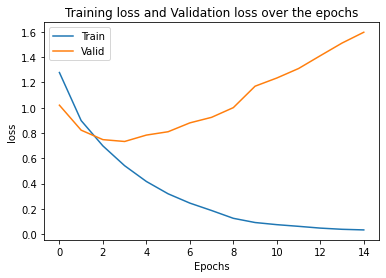

In [ ]:
plt.plot(range(15),train_losses, label = "Train")
plt.plot(range(15),valid_losses, label = "Valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Training loss and Validation loss over the epochs")
plt.show()


In [ ]:
valid_f1_scores=[x.cpu() for x in valid_f1_scores]
train_f1_scores=[x.cpu() for x in train_f1_scores]


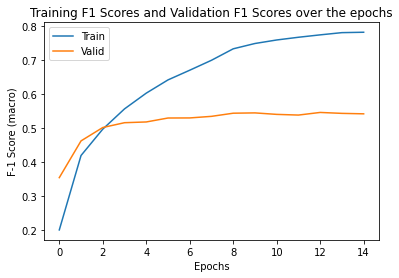

In [ ]:
plt.plot(range(15),train_f1_scores, label = "Train")
plt.plot(range(15),valid_f1_scores, label = "Valid")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("F-1 Score (macro)")
plt.title("Training F1 Scores and Validation F1 Scores over the epochs")
plt.show()


##Creating the submission files

In [ ]:
# DO NOT EDIT
with open("valid_losses.txt","w") as f:
    for x in valid_losses:
        f.write(str(x)+"\n")

with open("valid_f1_scores.txt","w") as f:
    for x in valid_f1_scores:
        f.write(str(x)+"\n")


with open("train_losses.txt","w") as f:
    for x in train_losses:
        f.write(str(x)+"\n")

with open("train_f1_scores.txt","w") as f:
    for x in train_f1_scores:
        f.write(str(x)+"\n")

with open("predictions.txt","w") as f:
    f.write("\n\n".join(["\n".join(x) for x in output]))
